<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/cids_and_sids_from_pubchem_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectives
* Build binary classification models that predict activity/inactivity of small molecules against human aromatase using supervised learning methods.
* Evaluate the performance of the developed models using performance measures.

# Imports

In [47]:
! pip install rdkit --quiet
! pip install pysmiles --quiet
!pip install karateclub --quiet
!pip install git+https://github.com/samoturk/mol2vec --quiet


     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 1.8 MB 19.3 MB/s 
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 1.6 MB 7.6 MB/s 


In [48]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from karateclub import Graph2Vec


In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from pylab import rcParams

In [32]:
import pandas as pd
import requests
import numpy as np
import time
import io
import rdkit
import networkx
import networkx as nx
import sklearn 
from io import StringIO
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
plt.rcParams['figure.figsize'] = [10, 5]

# Load data from PubChem

Data is available at:https://pubchem.ncbi.nlm.nih.gov/bioassay/743139

In [8]:

def load_data_from_a_PubChem_assay(assay_id=743139):
    url = f'https://pubchem.ncbi.nlm.nih.gov/assay/pcget.cgi?query=download&record_type=datatable&actvty=all&response_type=save&aid={assay_id}'
    df_raw=pd.read_csv(url)
    #print(df_raw.head())
    return(df_raw)
df_raw=load_data_from_a_PubChem_assay()


In [132]:
df_raw.head()

,pc_result_tag,sid,cid,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
3,1,144203552.0,12850184.0,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
4,2,144203553.0,89753.0,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
5,3,144203554.0,9403.0,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
6,4,144203555.0,13218779.0,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
7,5,144203556.0,142766.0,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),active antagonist,15.5454,-115.803,active antagonist,14.9601,-76.8218,NCI


##Pre-Processing

In [9]:
#remove the first 2 raws as these just provide descriptiom
df_raw = df_raw[3:]
#rename columns
col_names_map = {'PUBCHEM_RESULT_TAG' : 'pc_result_tag', 
                 'PUBCHEM_SID' : 'sid', 
                 'PUBCHEM_CID' : 'cid',
                 'PUBCHEM_ACTIVITY_OUTCOME' : 'activity_outcome', 
                 'PUBCHEM_ACTIVITY_SCORE' : 'activity_score',
                 'PUBCHEM_ACTIVITY_URL' : 'activity_url', 
                 'PUBCHEM_ASSAYDATA_COMMENT' : 'assay_data_comment', 
                 'Activity Summary' : 'activity_summary',
                 'Antagonist Activity' : 'antagonist_activity', 
                 'Antagonist Potency (uM)' : 'antagonist_potency', 
                 'Antagonist Efficacy (%)' : 'antagonist_efficacy',
                 'Viability Activity' : 'viability_activity', 
                 'Viability Potency (uM)' : 'viability_potency',
                 'Viability Efficacy (%)' : 'viability_efficacy', 
                 'Sample Source' : 'sample_source' }
df_raw = df_raw.rename(columns = col_names_map)
#Select active/inactive compounds for model building
df = df_raw[ (df_raw['activity_summary'] == 'active agonist' ) | 
             (df_raw['activity_summary'] == 'active antagonist' ) |
             (df_raw['activity_summary'] == 'inactive' ) ]


In [8]:
print(len(df['sid'].unique()))
print(len(df['cid'].unique()))

8553
6864


In [10]:
#Drop substances without associated CIDs.
df = df.dropna( subset=['cid'] )

#Remove CIDs with conflicting activities
cid_conflict = []
idx_conflict = []

for mycid in df['cid'].unique() :
    
    outcomes = df[ df.cid == mycid ].activity_summary.unique()
    
    if len(outcomes) > 1 :
        
        idx_tmp = df.index[ df.cid == mycid ].tolist()
        idx_conflict.extend(idx_tmp)
        cid_conflict.append(mycid)

print("#", len(cid_conflict), "CIDs with conflicting activities [associated with", len(idx_conflict), "rows (SIDs).]")
df = df.drop(idx_conflict)

#Remove redundant data

df = df.drop_duplicates(subset='cid')  # remove duplicate rows except for the first occurring row.
print(len(df['sid'].unique()))
print(len(df['cid'].unique()))

# 65 CIDs with conflicting activities [associated with 146 rows (SIDs).]
6798
6798


##Label Encoder of targets

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['activity'] = [ 0 if x == 'inactive' else 1 for x in df['activity_summary'] ]
df['activity']=le.fit_transform(df['activity'])

In [11]:
df.groupby('activity_summary').count()


,pc_result_tag,sid,cid,activity_outcome,activity_score,activity_url,assay_data_comment,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source,activity
activity_summary,,,,,,,,,,,,,,,
active agonist,451,451,451,451,451,0,0,451,451,451,451,44,432,451,451
active antagonist,291,291,291,291,291,0,0,291,290,291,291,88,275,291,291
inactive,6056,6056,6056,6056,6056,0,0,6056,0,6056,6056,269,5970,6056,6056


In [12]:
df.groupby('activity').count()


,pc_result_tag,sid,cid,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
activity,,,,,,,,,,,,,,,
0,6056,6056,6056,6056,6056,0,0,6056,6056,0,6056,6056,269,5970,6056
1,742,742,742,742,742,0,0,742,742,741,742,742,132,707,742


# Download structure information for each compound from PubChem


In [12]:
def download_smiles_given_cids_from_pubmed(list_of_cids,chunk_size = 200): #returns df of smiles and cids
    df_smiles = pd.DataFrame()

    num_cids = len(list_of_cids)
    list_dfs = []
    if num_cids % chunk_size == 0 :
        num_chunks = int( num_cids / chunk_size )
    else :
        num_chunks = int( num_cids / chunk_size ) + 1

    print("# CIDs = ", num_cids)
    print("# CID Chunks = ", num_chunks, "(chunked by ", chunk_size, ")")

    for i in range(0, num_chunks) :
        idx1 = chunk_size * i
        idx2 = chunk_size * (i + 1)
        cidstr = ",".join( str(x) for x in list_of_cids[idx1:idx2] )

        url = ('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + cidstr + '/property/IsomericSMILES/TXT')
        res = requests.get(url)
        data = pd.read_csv( StringIO(res.text), header=None, names=['smiles'] )
        list_dfs.append(data)
        
        time.sleep(0.2)
        
        if ( i % 5 == 0 ) :
            print("Processing Chunk ", i)
    df_smiles = pd.concat(list_dfs,ignore_index=True)
    df_smiles[ 'cid' ] = list_of_cids   

    return df_smiles

In [13]:
df_smiles=download_smiles_given_cids_from_pubmed(df.cid.astype(int).tolist())

# CIDs =  6798
# CID Chunks =  34 (chunked by  200 )
Processing Chunk  0
Processing Chunk  5
Processing Chunk  10
Processing Chunk  15
Processing Chunk  20
Processing Chunk  25
Processing Chunk  30


In [14]:
def generate_maccs_keys_from_smiles_and_cids(smiles): #takes a df and returns df of cids and associated mac
    fps=dict()

    for idx, row in smiles.iterrows() :
        
        mol = Chem.MolFromSmiles(row.smiles)
        
        if mol == None :
            print("Can't generate MOL object:", "CID", row.cid, row.smiles)
        else:
            fps[row.cid] = [row.cid] + list(MACCSkeys.GenMACCSKeys(mol).ToBitString())


    # Generate column names
    fpbitnames = []

    fpbitnames.append('cid')
    #name the columns
    for i in range(0,167):   # from MACCS000 to MACCS166
        fpbitnames.append( "maccs" + str(i).zfill(3) )

    df_fps = pd.DataFrame.from_dict(fps, orient='index', columns=fpbitnames)
    return(df_fps)
    

In [15]:
df_fps=generate_maccs_keys_from_smiles_and_cids(df_smiles)

Can't generate MOL object: CID 28145 [NH4+].[NH4+].F[Si-2](F)(F)(F)(F)F
Can't generate MOL object: CID 28127 F[Si-2](F)(F)(F)(F)F.[Na+].[Na+]


In [16]:
#merge activity data and maccs keys
df_activity = df[['cid','activity']]
df_data = df_activity.join(df_fps.set_index('cid'), on='cid')
#drop the rows for which the activity could  not be generated
df_data = df_data.dropna()
df_data.to_csv('df_data.csv')

len(df_data)


6796

In [18]:
df_data.iloc[:,:]

,cid,activity,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
3,12850184.0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
4,89753.0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
5,9403.0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
6,13218779.0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,0
12,637566.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10481,31070.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
10482,3289.0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
10483,74483.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
10484,8343.0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


#Split data into targets and features

In [17]:
#s[lit data into targets and geatures]
X = df_data.iloc[:,2:]
y = df_data['activity'].values

In [18]:
print(X.head(3), X.shape)
y[:3]

  maccs000 maccs001 maccs002 maccs003 maccs004 maccs005 maccs006 maccs007  \
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   
5        0        0        0        0        0        0        0        0   

  maccs008 maccs009  ... maccs157 maccs158 maccs159 maccs160 maccs161  \
3        0        0  ...        1        0        1        0        0   
4        0        0  ...        1        0        1        0        0   
5        0        0  ...        1        0        1        1        0   

  maccs162 maccs163 maccs164 maccs165 maccs166  
3        0        0        1        0        1  
4        0        0        1        0        1  
5        1        1        1        1        0  

[3 rows x 167 columns] (6796, 167)


array([0, 0, 0])

#Remove the maccs key with 0 variance

In [19]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
X=sel.fit_transform(X)
X.shape  #- After removal

(6796, 163)

#Train-Test-Split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

(5436, 163) (1360, 163) (5436,) (1360,)
594 148


In [24]:
print("# inactives : ", len(y_train) - y_train.sum())
print("# actives   : ", y_train.sum())

# inactives :  594
# actives   :  594


#Downsampling

In [23]:
# Indicies of each class' observations
idx_inactives = np.where( y_train == 0 )[0]
idx_actives   = np.where( y_train == 1 )[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Randomly sample from inactives without replacement
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(idx_inactives, size=num_actives, replace=False)

# Join together downsampled inactives with actives
X_train = np.vstack((X_train[idx_inactives_downsampled], X_train[idx_actives]))
y_train = np.hstack((y_train[idx_inactives_downsampled], y_train[idx_actives]))

In [25]:
print("# inactives : ", len(y_train) - y_train.sum())
print("# actives   : ", y_train.sum())
print(len(y_train))
print(len(X_train))
print(len(X_train[0]))

# inactives :  594
# actives   :  594
1188
1188
163


#Random Forest

In [26]:
from sklearn.naive_bayes import BernoulliNB        #-- Naive Bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier    #-- Decision Tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [31]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit( X_train ,y_train )
y_true, y_pred = y_train, clf.predict( X_train )

In [32]:
CMat = confusion_matrix( y_true, y_pred)

In [33]:
acc  = accuracy_score( y_true, y_pred )

sens = CMat[ 1 ][ 1 ] / ( CMat[ 1 ][ 0 ] + CMat[ 1 ][ 1 ] )    # TP / (FN + TP)
spec = CMat[ 0 ][ 0 ] / ( CMat[ 0 ][ 0 ] + CMat[ 0 ][ 1 ] )    # TN / (TN + FP )
bacc = (sens + spec) / 2

y_score = clf.predict_proba( X_train )[:, 1]
auc = roc_auc_score( y_true, y_score )

In [35]:
print("#-- Accuracy          = ", acc)
print("#-- Balanced Accuracy = ", bacc)
print("#-- Sensitivity       = ", sens)
print("#-- Specificity       = ", spec)
print("#-- AUC-ROC           = ", auc)

#-- Accuracy          =  0.7255892255892256
#-- Balanced Accuracy =  0.7255892255892256
#-- Sensitivity       =  0.7676767676767676
#-- Specificity       =  0.6835016835016835
#-- AUC-ROC           =  0.7973208516137809


In [34]:
y_true, y_pred = y_test, clf.predict(X_test)
CMat = confusion_matrix( y_true, y_pred )    #-- generate confusion matrix
print(CMat)

[[784 428]
 [ 41 107]]


In [121]:
acc  = accuracy_score( y_true, y_pred )

sens = CMat[ 1 ][ 1 ] / ( CMat[ 1 ][ 0 ] + CMat[ 1 ][ 1 ] )
spec = CMat[ 0 ][ 0 ] / ( CMat[ 0 ][ 0 ] + CMat[ 0 ][ 1 ] )
bacc = (sens + spec) / 2

y_score = clf.predict_proba( X_test )[:, 1]
auc = roc_auc_score( y_true, y_score )

print("#-- Accuracy          = ", acc)
print("#-- Balanced Accuracy = ", bacc)
print("#-- Sensitivity       = ", sens)
print("#-- Specificity       = ", spec)
print("#-- AUC-ROC           = ", auc)

#-- Accuracy          =  0.6551470588235294
#-- Balanced Accuracy =  0.68491882972081
#-- Sensitivity       =  0.722972972972973
#-- Specificity       =  0.6468646864686468
#-- AUC-ROC           =  0.7449798189278387


In [122]:
print( classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.65      0.77      1212
           1       0.20      0.72      0.31       148

    accuracy                           0.66      1360
   macro avg       0.58      0.68      0.54      1360
weighted avg       0.87      0.66      0.72      1360



#Grid Search CV for Random Forest

In [127]:
from sklearn.model_selection import GridSearchCV
scores = [ 'roc_auc', 'balanced_accuracy' ]

ncvs = 10

max_depth_range         = np.linspace( 3, 7, num=5, dtype='int32' )
n_estimators  = np.linspace( 10, 300, num=5, dtype='int32' )
criterion  = ["gini", "entropy", "log_loss"]

param_grid = dict( max_depth=max_depth_range,
                   n_estimators=n_estimators,
                   criterion=criterion )

clf = GridSearchCV( RandomForestClassifier( random_state=0 ),
                    param_grid=param_grid, cv=ncvs, scoring=scores, refit='roc_auc',
                    return_train_score = True)

In [128]:
clf.fit( X_train, y_train )
print("Best parameter set", clf.best_params_)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/p

Best parameter set {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 82}


In [129]:
means_1a = clf.cv_results_['mean_train_roc_auc']
stds_1a  = clf.cv_results_['std_train_roc_auc']

means_1b = clf.cv_results_['mean_test_roc_auc']
stds_1b  = clf.cv_results_['std_test_roc_auc']

means_2a = clf.cv_results_['mean_train_balanced_accuracy']
stds_2a  = clf.cv_results_['std_train_balanced_accuracy']

means_2b = clf.cv_results_['mean_test_balanced_accuracy']
stds_2b  = clf.cv_results_['std_test_balanced_accuracy']

iterobjs = zip( means_1a, stds_1a, means_1b, stds_1b,
                means_2a, stds_2a, means_2b, stds_2b, clf.cv_results_['params'] )

for m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b, params in iterobjs :

    print( "Grid %r : %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f"
           % ( params, m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b))

Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 10} : 0.8163 0.0071 0.7883 0.0277 0.7469 0.0051 0.7213 0.0419
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 82} : 0.8283 0.0036 0.8018 0.0271 0.7511 0.0055 0.7348 0.0383
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 155} : 0.8292 0.0041 0.8050 0.0264 0.7502 0.0061 0.7315 0.0392
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 227} : 0.8301 0.0038 0.8041 0.0262 0.7506 0.0052 0.7298 0.0384
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 300} : 0.8311 0.0035 0.8047 0.0258 0.7511 0.0057 0.7298 0.0368
Grid {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 10} : 0.8448 0.0044 0.7963 0.0312 0.7652 0.0075 0.7289 0.0427
Grid {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 82} : 0.8566 0.0029 0.8147 0.0251 0.7752 0.0047 0.7365 0.0408
Grid {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 155} : 0.8564 0.0029 0.8144 0.0268 0.7759 0.0050 0.7340 0.0406
Grid {'criterion': 'gini', '

In [131]:
y_true, y_pred = y_test, clf.predict(X_test)    #-- Apply the model to predict the test set compounds' activity.
CMat = confusion_matrix( y_true, y_pred ) 
print(CMat)
acc  = accuracy_score( y_true, y_pred )

sens = CMat[ 1 ][ 1 ] / ( CMat[ 1 ][ 0 ] + CMat[ 1 ][ 1 ] )    # TP / (FN + TP)
spec = CMat[ 0 ][ 0 ] / ( CMat[ 0 ][ 0 ] + CMat[ 0 ][ 1 ] )    # TN / (TN + FP )
bacc = (sens + spec) / 2

y_score = clf.predict_proba( X_test )[:, 1]
auc = roc_auc_score( y_true, y_score )
print("#-- Accuracy          = ", acc)
print("#-- Balanced Accuracy = ", bacc)
print("#-- Sensitivity       = ", sens)
print("#-- Specificity       = ", spec)
print("#-- AUC-ROC           = ", auc)

[[885 327]
 [ 41 107]]
#-- Accuracy          =  0.7294117647058823
#-- Balanced Accuracy =  0.7265854963874766
#-- Sensitivity       =  0.722972972972973
#-- Specificity       =  0.7301980198019802
#-- AUC-ROC           =  0.800051288912675


# Moving on to graphs 

In [21]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                  bond_type=str(bond.GetBondType())[0:])
        
    return G

In [22]:
 #let s suppose we have a list of cids with smiles and the associated  activity target 
 
df3=df_activity.join(df_smiles.set_index('cid'), on='cid')
df3.head(3)

,cid,activity,smiles
3,12850184.0,0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...
4,89753.0,0,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...
5,9403.0,0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...


In [23]:

def list_of_smiles_to_list_of_graph_molecules(list_of_smiles):
   list_of_molecules=[Chem.MolFromSmiles(smiles) for smiles in list_of_smiles] 
   print(len(list_of_molecules),len(list_of_smiles ))
   i=0
   list_of_graph_molecules=[]
   for mol in list_of_molecules:
      try:
          list_of_graph_molecules.append(mol_to_nx(mol))
          i=i+1
      except:
          print(i)
          list_of_graph_molecules.append('None')
          i=i+1
   return list_of_graph_molecules


In [24]:
list_of_smiles=df3.smiles.tolist()
list_of_graph_molecules=list_of_smiles_to_list_of_graph_molecules(list_of_smiles)
df3['graphs']=list_of_graph_molecules
#remove the two indices returned above
df3 = df3[df3['graphs']!='None']
print(df3)

6798 6798
1933
6270
              cid  activity  \
3      12850184.0         0   
4         89753.0         0   
5          9403.0         0   
6      13218779.0         0   
12       637566.0         0   
...           ...       ...   
10481     31070.0         0   
10482      3289.0         0   
10483     74483.0         1   
10484      8343.0         0   
10485     47898.0         0   

                                                  smiles  \
3      C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...   
4      C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...   
5      C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...   
6             C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N   
12                                  CC(=CCC/C(=C/CO)/C)C   
...                                                  ...   
10481                CCOP(=O)(NC(C)C)OC1=CC(=C(C=C1)SC)C   
10482                                 CCCSP(=O)(OCC)SCCC   
10483  C(C(C(C(C(F)(F)S(=O)(=O)O)(F)F)(F)F)(F)F)(C(C(...   
10484  

In [25]:
x=np.array(df3['graphs'][:1])
print(nx.get_node_attributes(x[0], 'atom_symbol'))

{0: 'C', 1: 'C', 2: 'O', 3: 'C', 4: 'C', 5: 'C', 6: 'C', 7: 'O', 8: 'O', 9: 'O', 10: 'O', 11: 'O', 12: 'O', 13: 'C', 14: 'C', 15: 'O', 16: 'C', 17: 'C', 18: 'C', 19: 'C', 20: 'O', 21: 'O', 22: 'O', 23: 'O', 24: 'O', 25: 'O', 26: 'Ca'}


In [26]:
subset=list_of_graph_molecules[:13]
list_of_graph_molecules[13]
list_of_smiles[13]

'C1CCN(CC1)CCC(C2=CC=CC=C2)(C3=CC=CC=C3)O'

In [45]:
seed=67

def weight_to_color(bond_type):
    
    #print(bond_type)
    integer=sum([ord(c) for c in bond_type])
    integer=int(integer*len(bond_type)*ord(bond_type[0])+ord(bond_type[1]))
    random.seed(seed)
    random_hex= "#%06x" % random.randint(integer, 0x49144F)
    
    return random_hex
def get_edge_color_list(mol_nx):
    
    edge_color=[ weight_to_color(data[2]) for data in mol_nx.edges(data = 'bond_type')] 
    #print(edge_color)
    return edge_color

def return_colors_for_atoms(mol_nx):
    random.seed(767)

    color_map = {}
 
    for idx in mol_nx.nodes():
      if mol_nx.nodes[idx]['atom_symbol'] not in color_map:
         
          color_map[mol_nx.nodes[idx]['atom_symbol']] ="#%06x" % random.randint(sum([ord(c) for c in mol_nx.nodes[idx]['atom_symbol']]), 0xFFFFFF) 

    mol_colors = []
    for idx in mol_nx.nodes():
        if (mol_nx.nodes[idx]['atom_symbol'] in color_map):
            mol_colors.append(color_map[mol_nx.nodes[idx]['atom_symbol']])
        else:
            mol_colors.append('gray')
    return mol_colors

def get_labels(mol_nx):
    return nx.get_node_attributes(mol_nx, 'atom_symbol')
#set(nx.get_node_attributes(mol_nx, 'atom_symbol').values())
#colors=[i/len(mol_nx.nodes) for i in range(len(mol_nx.nodes))]

def draw_one_mol(mol_nx, ax=None):
  
    nx.draw( mol_nx,
            labels= get_labels(mol_nx),
            with_labels = True,
            node_color=return_colors_for_atoms(mol_nx),
            node_size=100,
            width = 4,
            linewidths=3,
            edge_color=get_edge_color_list(mol_nx),
            ax=ax)
    


def get_adjency_matrix(mol_nx):
    # print out the adjacency matrix ---------------------------------------------- 
    matrix = nx.to_numpy_matrix(mol_nx)
    print(matrix)
    return matrix

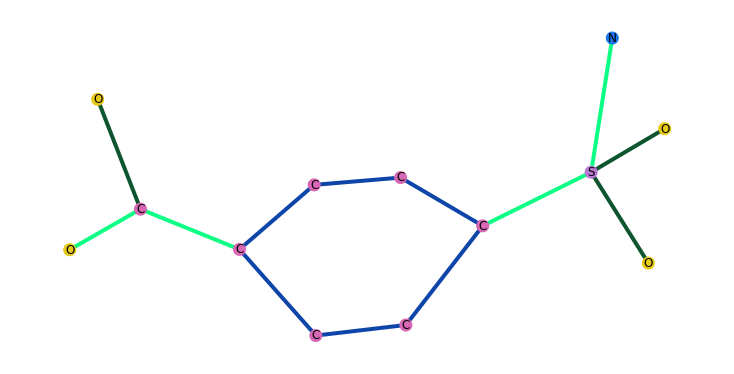

In [115]:
draw_one_mol(list_of_graph_molecules[12])

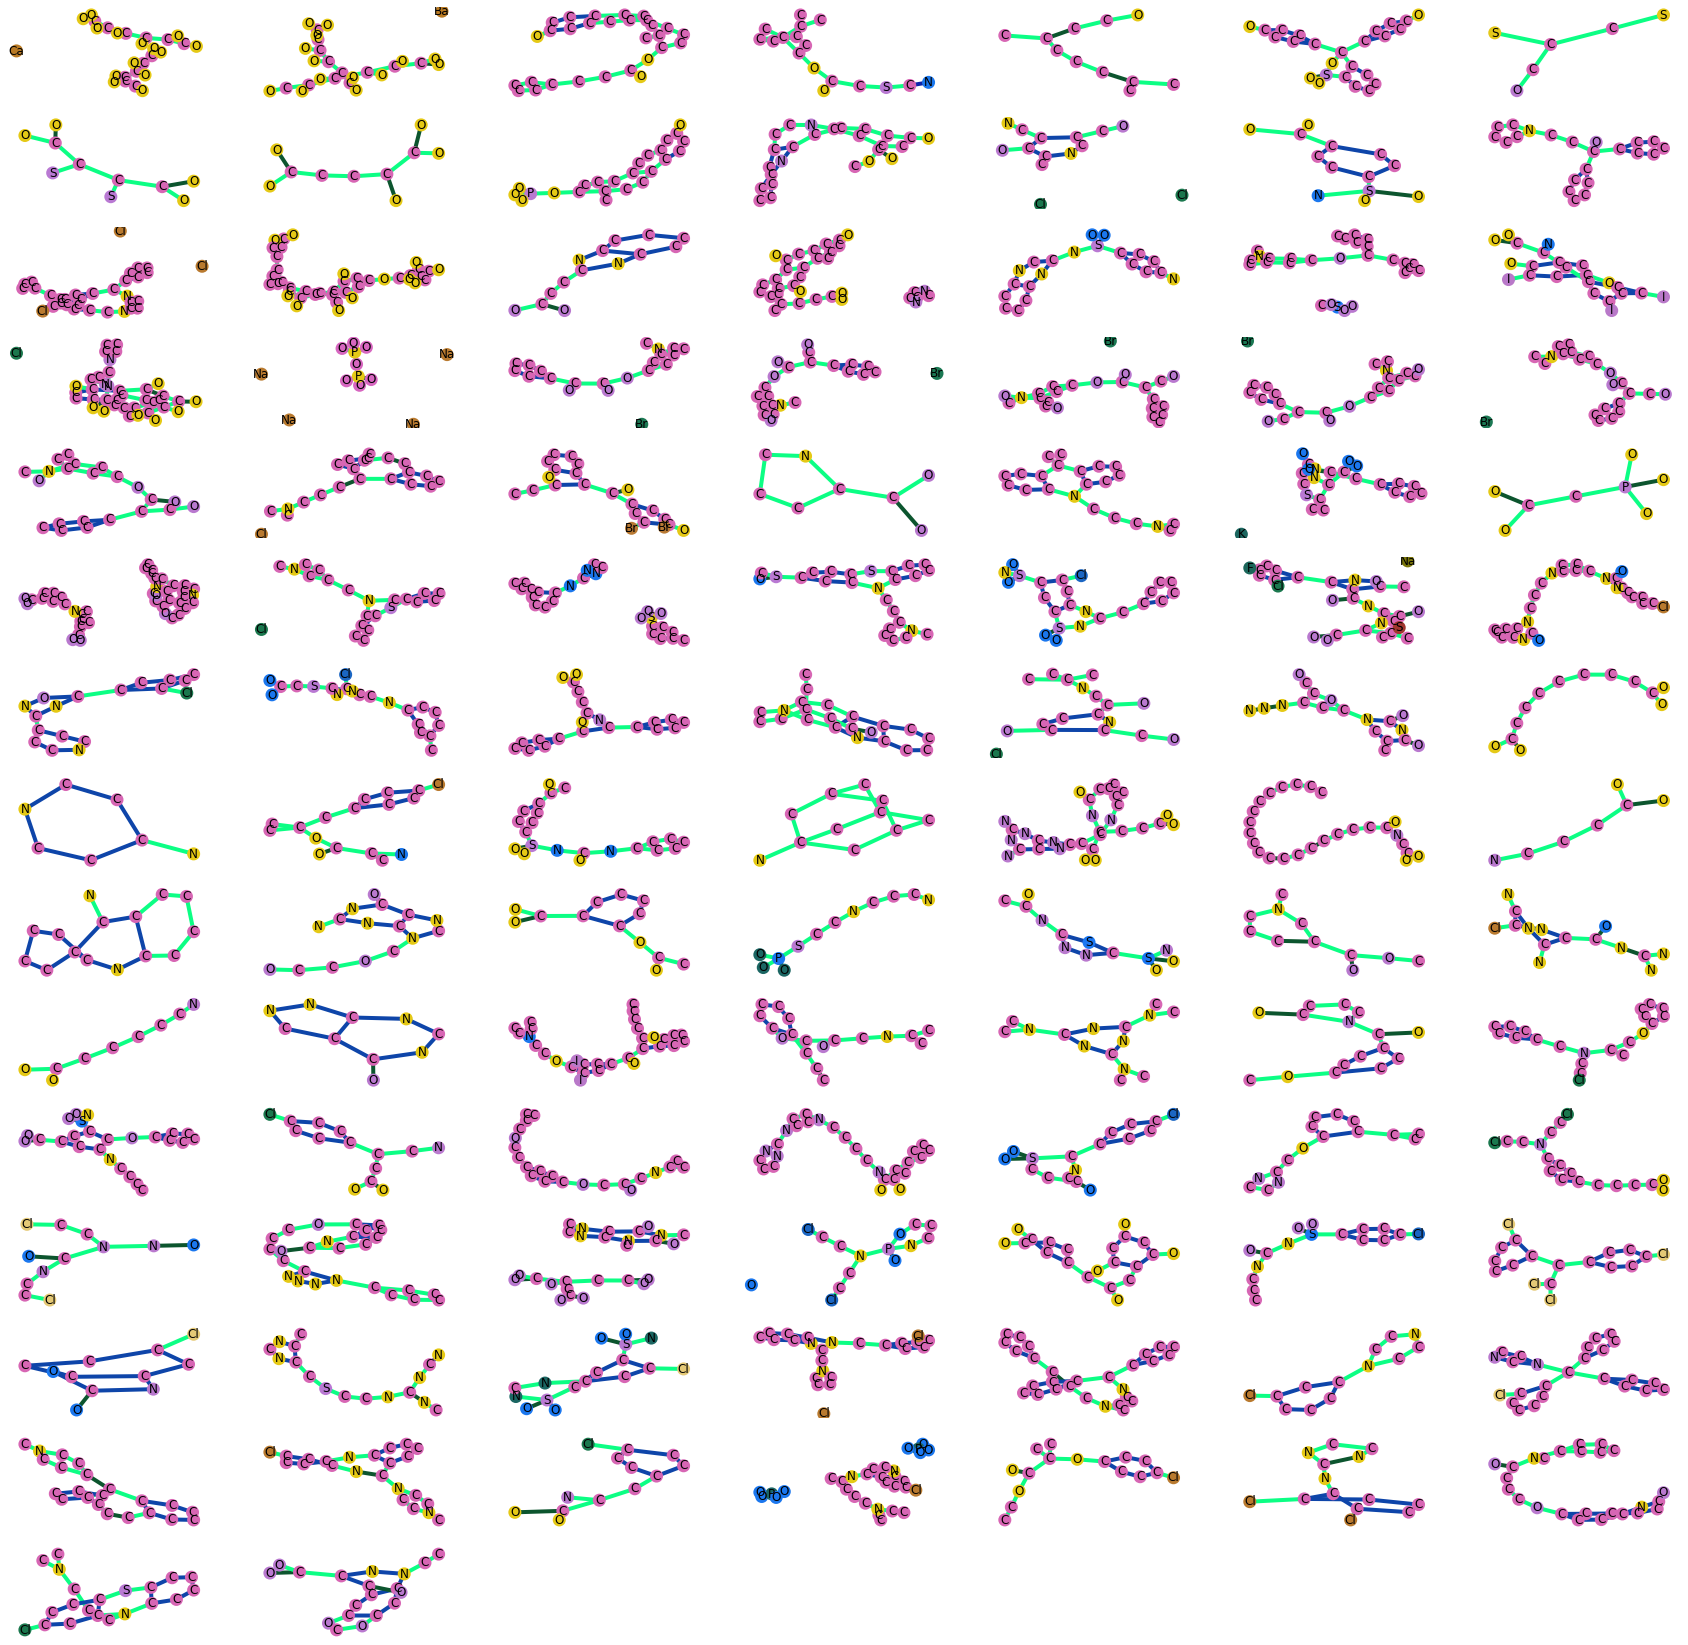

In [46]:
def draw_graphs(list_of_graph_molecules, num_per_line=3):
      ixs=[]
      num_per_line_ax_n=0
      if len(list_of_graph_molecules)%num_per_line==0:
       lines=int(len(list_of_graph_molecules)/num_per_line)
      else:
        lines=len(list_of_graph_molecules)//num_per_line+1
        num_per_line_ax_n=len(list_of_graph_molecules) % num_per_line
       
        for i in range(num_per_line-num_per_line_ax_n):
          ix=lines-1,num_per_line-i-1
          ixs.append(ix)
          
      #print(lines)
      fig, ax = plt.subplots(lines, num_per_line)
      fig.set_figheight(30)
      fig.set_figwidth(30)
      for i, mol_nx in enumerate(list_of_graph_molecules):
     
        ix = np.unravel_index(i, ax.shape)
        draw_one_mol(mol_nx, ax=ax[ix])
      for ix in ixs:
           ax[ix].set_axis_off()
 
          
    
draw_graphs(list_of_graph_molecules[:100], num_per_line=7)


Graph2vec

In [49]:
model = Graph2Vec()
model.fit(df3['graphs'])

In [88]:
cid_graph2vec = model.get_embedding()
civ_graph2vec = pd.DataFrame(cid_graph2vec)
print(">>> hiv_graph2vec shape = ", civ_graph2vec.shape)
print(civ_graph2vec)
print()

>>> hiv_graph2vec shape =  (6796, 128)
           0         1         2         3         4         5         6    \
0     0.056866 -0.040604 -0.084374  0.071747 -0.001746 -0.047096  0.019704   
1     0.052713 -0.040390 -0.094574  0.078327  0.009586 -0.046076  0.023624   
2     0.063741 -0.049465 -0.101259  0.086930  0.015603 -0.046683  0.030397   
3     0.089636 -0.078870 -0.148542  0.118583  0.005844 -0.060271  0.040868   
4     0.050742 -0.044703 -0.083584  0.066482  0.006734 -0.034004  0.023442   
...        ...       ...       ...       ...       ...       ...       ...   
6791  0.071806 -0.059286 -0.118750  0.097725  0.007229 -0.050043  0.032491   
6792  0.069034 -0.068219 -0.128737  0.108477 -0.000417 -0.055607  0.028575   
6793  0.100576 -0.080578 -0.175555  0.161096  0.019344 -0.080483  0.002570   
6794  0.039274 -0.044401 -0.070157  0.069036  0.004009 -0.038726  0.019997   
6795  0.050733 -0.049261 -0.095026  0.076660  0.006973 -0.036645  0.023976   

           7         8  

In [63]:
df3

,cid,activity,smiles,graphs
3,12850184.0,0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,89753.0,0,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,9403.0,0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,13218779.0,0,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
12,637566.0,0,CC(=CCC/C(=C/CO)/C)C,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)"
...,...,...,...,...
10481,31070.0,0,CCOP(=O)(NC(C)C)OC1=CC(=C(C=C1)SC)C,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10482,3289.0,0,CCCSP(=O)(OCC)SCCC,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)"
10483,74483.0,1,C(C(C(C(C(F)(F)S(=O)(=O)O)(F)F)(F)F)(F)F)(C(C(...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10484,8343.0,0,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [81]:
df3['activity']

3        0
4        0
5        0
6        0
12       0
        ..
10481    0
10482    0
10483    1
10484    0
10485    0
Name: activity, Length: 6796, dtype: int64

In [91]:
civ_graph2vec.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)

civ_graph2vec=pd.concat([civ_graph2vec,df3['activity']],axis=1)


In [601]:
sum([ord(c) for c in 'THREECENTER'])

825

In [275]:
for i ,k in nx.get_node_attributes(mol_nx, 'atom_symbol').items():
      print(k)
      break

C


In [291]:
set(nx.get_node_attributes(mol_nx, 'atom_symbol').values())

{'C'}

In [284]:
(k[0][1] for k, v  in nx.get_node_attributes(mol_nx, 'atom_symbol'))

<generator object <genexpr> at 0x7fe43f2785d0>